In [6]:
import os
os.chdir(r'C:\Users\Navid\Documents\ds_salary_proj')

In [7]:
#!conda install seaborn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [72]:
df1 = pd.read_csv('df_data_scientist1.txt')
df2 = pd.read_csv('df_data_analyst1.txt')
df3 = pd.read_csv('df_data_scientist2.txt')
df4 = pd.read_csv('df_data_analyst2.txt')
df5 = pd.read_csv('df_data_engineer.txt')

In [73]:
df = df1.append(df2).append(df3).append(df4).append(df5)

In [75]:
df = df[df.duplicated().values != True]

In [76]:
df = df[df['Salary Range'] != '-1']

In [77]:
df = df.reset_index(drop=True)

In [78]:
df['salary_type'] = df['Salary Range'].apply(lambda x: x.split()[1] if 'Employer Provided Salary' not in x 
                                            else x.split('\n')[0])

In [79]:
df['Salary Range'] = df['Salary Range'].apply(lambda x: x.split("\n")[0] if 'Employer Provided Salary' not in x 
                                              else x.split('\n')[1])

In [80]:
df['Salary Range'] = df['Salary Range'].apply(lambda x: x.split()[0] if 'per hour' in x.lower() 
                                              else x)

In [81]:
print(df['salary_type'].unique())

['(Glassdoor' '(Employer' 'Per' 'Employer Provided Salary:']


In [82]:
df['per_hour'] = [1 if 'Per' in x else 0 for x in df['salary_type']]
df['Employer_reported'] = df['salary_type'].apply(lambda x: 1 if 'employer' in x.lower() else 0)

In [83]:
#extracting avg salary from slaray estimation
df['avg_salary'] = (df['Salary Range'].map(lambda x: x.split('-')[0].lstrip('$').rstrip('k')).astype('int32')
                    +df['Salary Range'].map(lambda x: x.split('-')[1].lstrip('$').rstrip('k')).astype('int32'))/2

In [20]:
#now lets find the avg salary of those reported per hour
#we multiply them by 2000 (approximately the number of hourse per year) and devide by 1000 (therefore, we just multiply it by 2)
df['avg_salary'] = df.apply(lambda x: x.avg_salary if x.per_hour != 1 else x.avg_salary*2,axis=1)

In [85]:
df.loc[df['Rating'] == -1, 'Company Name']
# it seems that the companies without rating, only have their name in the Company Name column

306     Penn State Health Milton S. Hershey Medical Ce...
746     Penn State Health Milton S. Hershey Medical Ce...
811     Penn State Health Milton S. Hershey Medical Ce...
997                               Intellitech Corporation
1106                                     Fulcrum Concepts
Name: Company Name, dtype: object

In [86]:
df['Company Name'] = df.apply(lambda x: x['Company Name'] if x['Rating'] == -1 else x['Company Name'].split("\n")[0] , axis = 1)

In [87]:
# Since in Location columns there are instacnes wuth differnt structre, such as 'Virgina', we need to replace them with 
# the same structure as others so that we can extract usefull info from them

# We remove the ones without specified location (United States)
df = df[df['Location'] != 'United States']
list_1 = []
for item in df.Location:
    if ',' not in item:
        list_1.append(item)

set(list_1)

{'Remote'}

In [88]:
df['state'] = df.apply(lambda x: x['Location'] if ',' not in x['Location']
                       else x['Location'].split(',')[1].lstrip() , axis = 1)
# we create a dict to use for mapping
state_convertor = {'Colorado' : 'CO' , 'Georgia' : 'GA' , 'Missouri' : 'MO' , 'New Jersey' : 'NJ' ,
             'Remote' : 'Remote' , 'Utah' : 'UT' , 'Virginia' : 'VA' , 'California' : 'CA' , 'Pennsylvania' : 'PA' ,
                'Puerto Rico' : 'PR' , 'Texas' : 'TX' , 'Illinois' : 'IL' }
df['state'] = df['state'].apply(lambda x: state_convertor[x] if x in state_convertor else x)

In [89]:
# # we are going to work on the size
# print(df.Size.value_counts())
# # Lets drop those company with unknown or -1 size
# df = df[(df['Size'] != '-1') & (df['Size'] != 'Unknown')]
# # Lets make a dictionary to convert differnt types of size to numbers, since they are compareable
# size_convertor = {'1 to 50 Employees':1 , '51 to 200 Employees':2 , '201 to 500 Employees':3 , 
#                  '501 to 1000 Employees':4 , '1001 to 5000 Employees':5 , '5001 to 10000 Employees':6 ,
#                  '10000+ Employees':7}
# df['Size'] = df['Size'].map(size_convertor)

In [90]:
# Now we want to change the founded year to age of the company
df['Founded'] = df['Founded'].apply(lambda x: -1 if x == -1 else 2020 - x)

In [91]:
#the length of the job description can be a usefull feature
df['desc_length'] = df['Job Description'].apply(lambda x: len(x))

In [92]:
df['Job Title'].value_counts()[:20]

Data Analyst                                140
Data Engineer                                68
Data Scientist                               68
Senior Data Analyst                          23
Senior Data Scientist                        20
Senior Data Engineer                         18
Machine Learning Engineer                    12
Software Engineer                             9
Lead Data Scientist                           8
Data Governance Analyst                       8
Marketing Data Analyst                        7
Lead Data Engineer                            6
Treasury Data Analyst                         6
Data Analyst II                               6
SAP Data Analyst                              6
Sr Data Analyst                               6
Data Scientist/ Analyst                       5
Business Intelligence Analyst                 5
Sr. Data Engineer                             5
SAP Materials Master Data Analyst - Temp      5
Name: Job Title, dtype: int64

In [93]:
# job title convertor
def title_extractor(title):
    if 'data scientist' in title.lower() or 'data science' in title.lower():
        return 'data scientist'
    elif 'data analyst' in title.lower() or 'marketing data analyst' in title.lower() or 'business intelligence analyst' in title.lower() or 'quantitative analyst' in title.lower():
        return 'data analyst'
    elif 'data engineer' in title.lower():
        return 'data engineer'
    elif 'machine learning engineer' in title.lower():
        return 'machine learning engineerr'
#     elif 'research scientist' in title.lower():
#         return 'research scientist'
#     elif 'lab scientist' in title.lower() or 'labratory scientist' in title.lower():
#         return 'lab scientist'
    else:
        return 'na'
    
    

In [94]:
# seniority extractor
def seniority(title):
    if 'senior' in title.lower() or 'sr' in title.lower() or 'lead' in title.lower() or 'principal' in title.lower() or 'sr.' in title.lower() or 'ii' in title.lower():
        return '1'
#     elif 'jr' in title.lower() or 'jr.' in title.lower() or 'junior' in title.lower():
#         return 'junior'
    else:
        return '0'
    

In [95]:
df['seniority'] = df['Job Title'].apply(seniority)
df['title'] = df['Job Title'].apply(title_extractor)

In [96]:
df.seniority.value_counts()

0    835
1    321
Name: seniority, dtype: int64

In [97]:
df.title.value_counts()

data analyst                  464
na                            285
data scientist                257
data engineer                 133
machine learning engineerr     17
Name: title, dtype: int64

In [98]:
df.loc[df['title']=='na','Job Title']

18                               Bioinformatics Scientist
19               Marketing Strategy and Analytics Manager
29      LabVIEW Developer/Architect (Control & Data Ac...
39             Medical Lab Scientist Virtual Hiring Event
47      COMPUTER SCIENTIST - ENGINEER - RESEARCH COMPU...
                              ...                        
1148           Site Reliability Engineer / DevOps / Linux
1149                               NETMAN Senior Engineer
1153                                    Sr. ETL Developer
1154                   Server Database Service Engineer I
1155                                       Data Architect
Name: Job Title, Length: 285, dtype: object

In [99]:
df = df[df.title != 'na']

In [100]:
df['python'] = df['Job Description'].apply(lambda x: 1 if 'python' in x.lower() else 0)
df['r studio'] = df['Job Description'].apply(lambda x: 1 if 'r studio' in x.lower() or 'r-studio' in x.lower() else 0)
df['ML'] = df['Job Description'].apply(lambda x: 1 if 'machine' in x.lower() or 'ml' in x.lower() else 0)
df['spark'] = df['Job Description'].apply(lambda x: 1 if 'spark' in x.lower() else 0)
df['deep_learning'] = df['Job Description'].apply(lambda x: 1 if 'tensorflow' in x.lower() or 'pytorch' in x.lower() else 0)
df['aws'] = df['Job Description'].apply(lambda x: 1 if 'aws' in x.lower() or 'cloud' in x.lower() else 0)


In [101]:
df.ML.value_counts()

0    514
1    357
Name: ML, dtype: int64

In [102]:
# some work on indsutry columns
manufacturing_list = []
for item in df.Industry:
    if 'manufacturing' in item.lower():
        manufacturing_list.append(item)
df['Industry'] = df['Industry'].apply(lambda x: 'manufacturing' if x in manufacturing_list else x)   
financial_list = ['Brokerage Services', 'Insurance Agencies & Brokerages', 'Financial Transaction Processing' , 
                 'Investment Banking & Asset Management', 'Lending', 'Banks & Credit Unions', 'Financial Analytics & Research']
df['Industry'] = df['Industry'].apply(lambda x: 'financial_related' if x in financial_list else x)
other_industries = df.Industry.value_counts().index[df.Industry.value_counts().values>10]
df['Industry'] = df['Industry'].apply(lambda x: 'other_industries' if x not in other_industries else x)

In [103]:
# education form job description
df['phd'] = df['Job Description'].apply(lambda x: 1 if ('phd' in x.lower()) or ('doctor' in x.lower())  else 0)
df['undergrad'] = df['Job Description'].apply(lambda x: 1 if 'bachelor' in x.lower() else 0)
df['master'] = df['Job Description'].apply(lambda x: 1 if 'master' in x.lower() else 0)

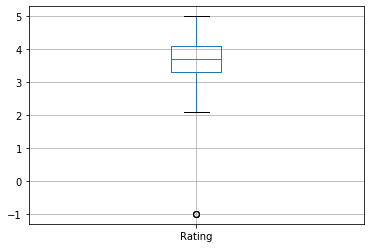

In [104]:
df.boxplot(column = 'Rating')

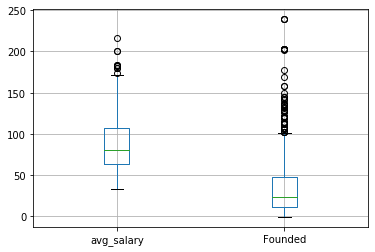

In [105]:
df.boxplot(column = ['avg_salary','Founded'])
# Many outliers for Founded

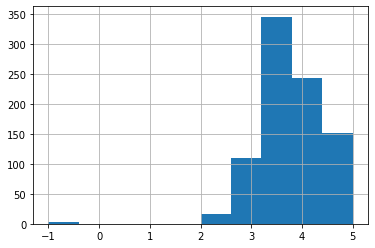

In [106]:
df.Rating.hist()
#pretty much normalized

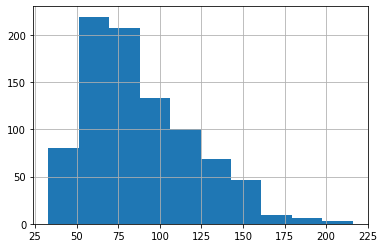

In [108]:
df.avg_salary.hist()
# it seems that the avg_salary data is skewed

In [109]:
#removing skewness
from scipy import stats
df['avg_salary'] ,fitted_lambda1 = stats.boxcox(df['avg_salary'])

In [110]:
df.corr()['avg_salary']

Unnamed: 0           0.142343
Rating               0.128367
Headquarters              NaN
Founded             -0.134736
Competitors               NaN
per_hour                  NaN
Employer_reported   -0.037850
avg_salary           1.000000
desc_length          0.113579
python               0.424035
r studio            -0.081091
ML                   0.346019
spark                0.264398
deep_learning        0.232316
aws                  0.214920
phd                  0.267251
undergrad           -0.215862
master               0.121988
Name: avg_salary, dtype: float64

In [111]:
df_cat = df[['Company Name','Location','Type of ownership', 'Industry', 'Sector','state','seniority',
               'title', 'python', 'r studio', 'ML', 'spark', 'deep_learning','Size']]

graph is Company Name , and the total number is 15


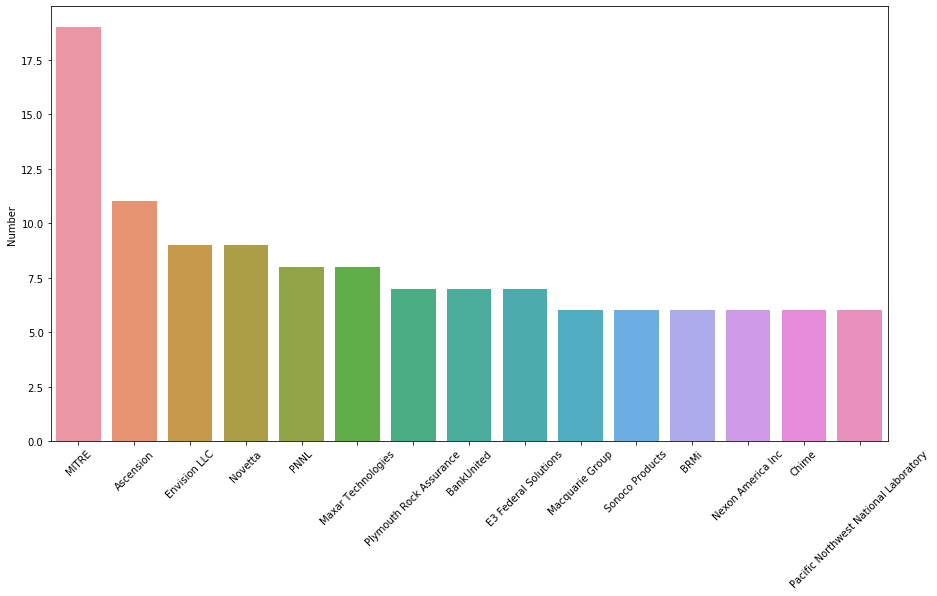

graph is Location , and the total number is 15


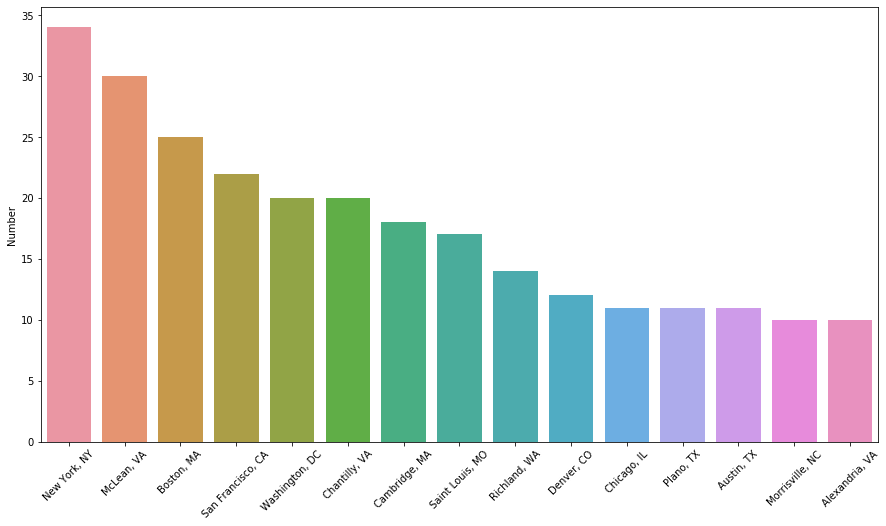

graph is Type of ownership , and the total number is 8


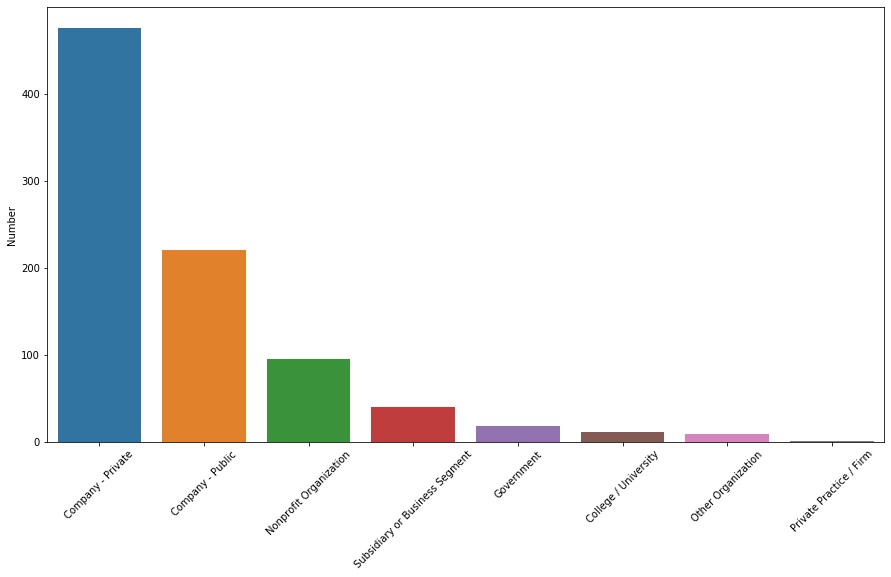

graph is Industry , and the total number is 15


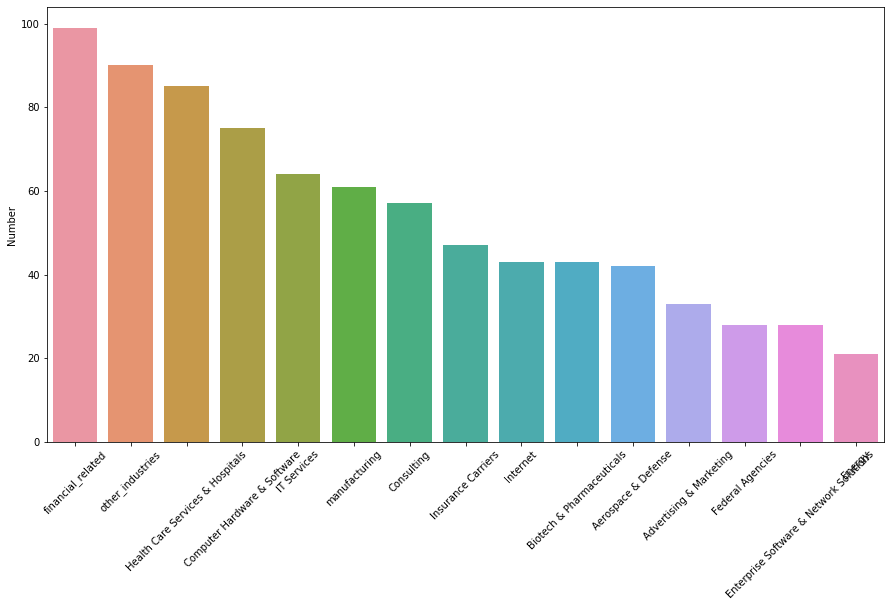

graph is Sector , and the total number is 15


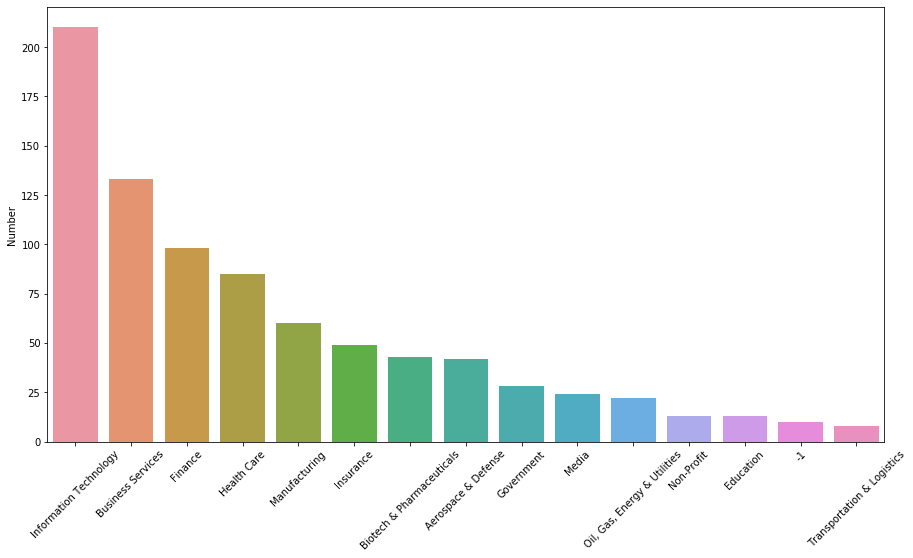

graph is state , and the total number is 15


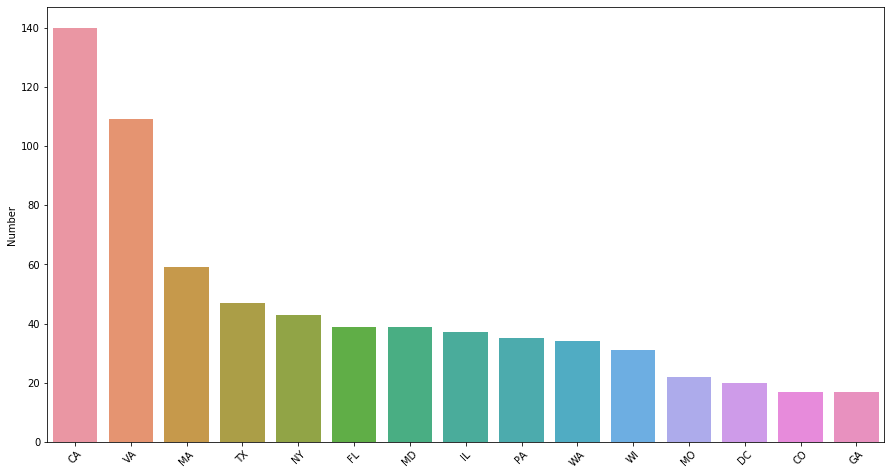

graph is seniority , and the total number is 2


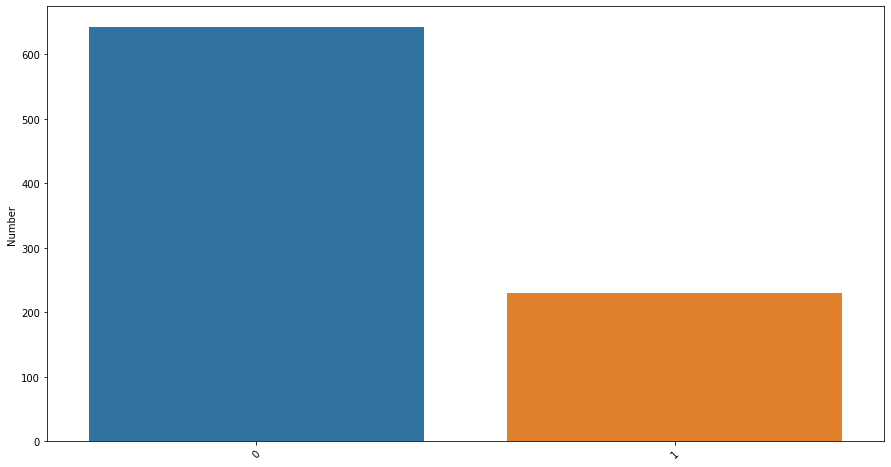

graph is title , and the total number is 4


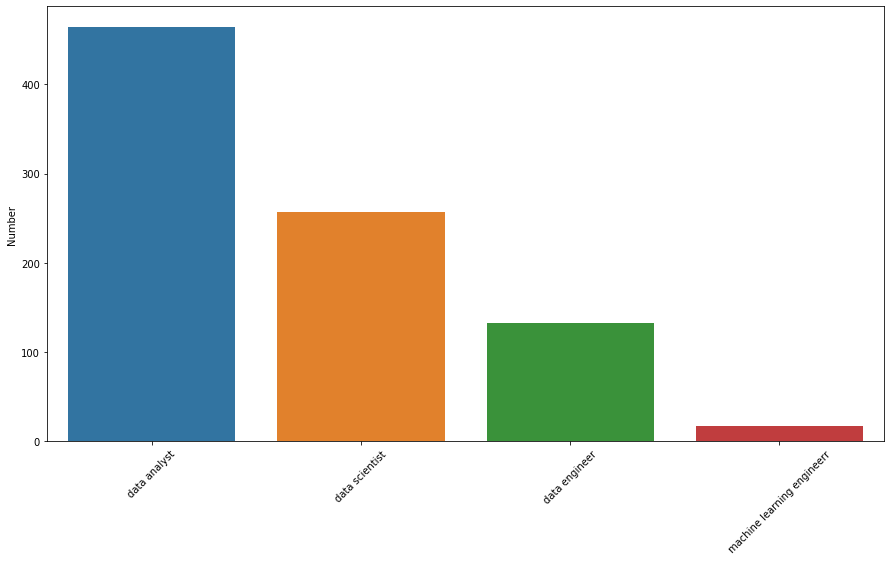

graph is python , and the total number is 2


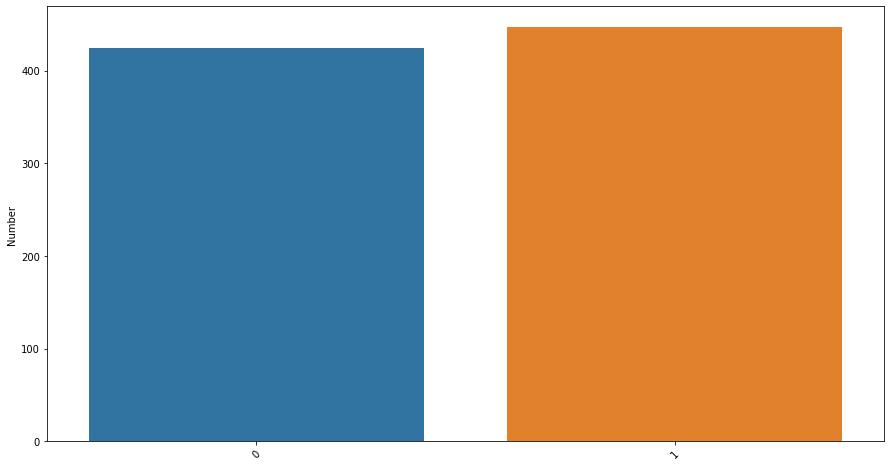

graph is r studio , and the total number is 2


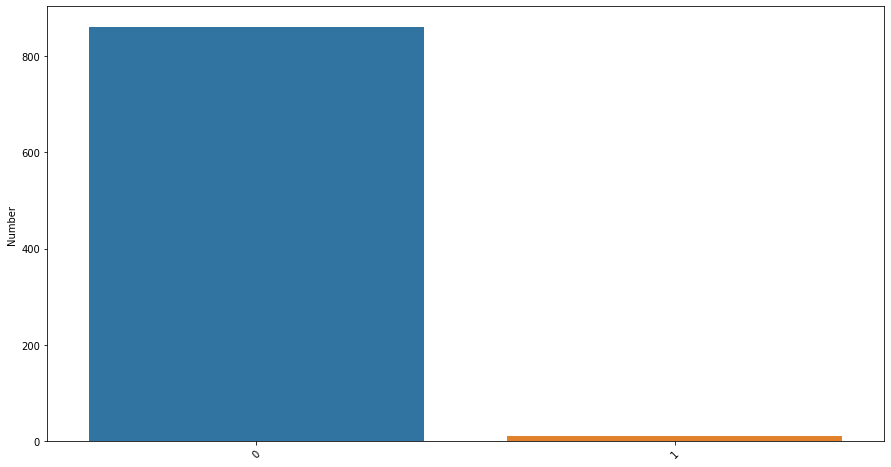

graph is ML , and the total number is 2


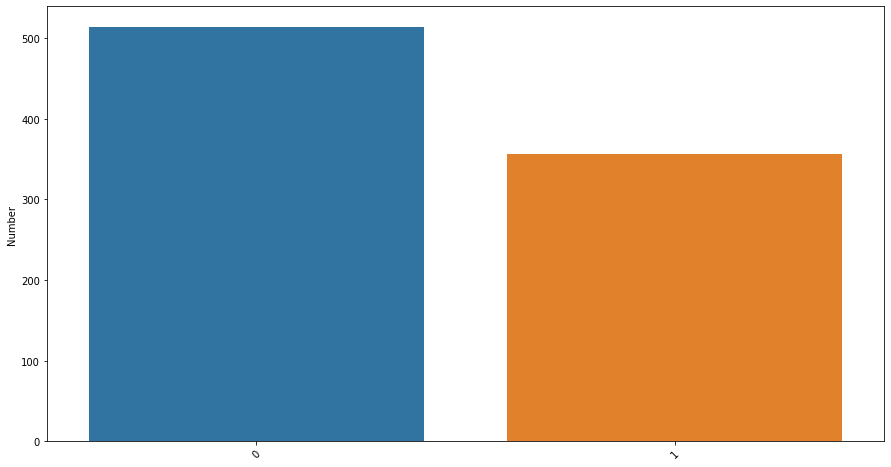

graph is spark , and the total number is 2


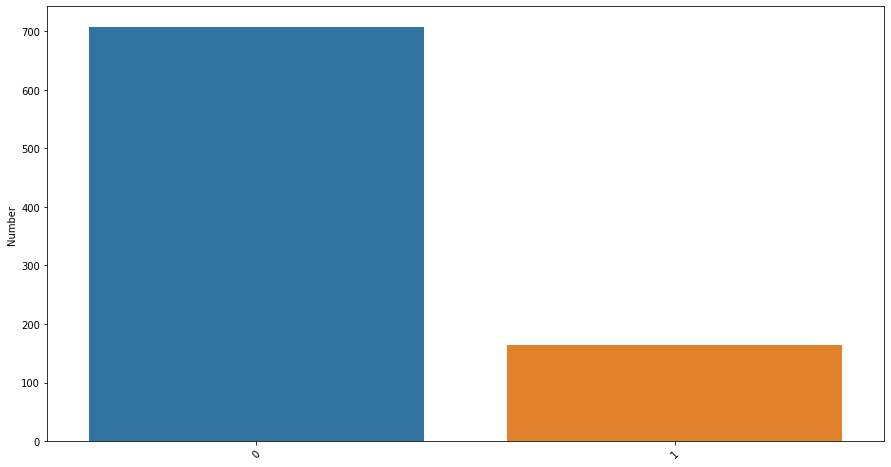

graph is deep_learning , and the total number is 2


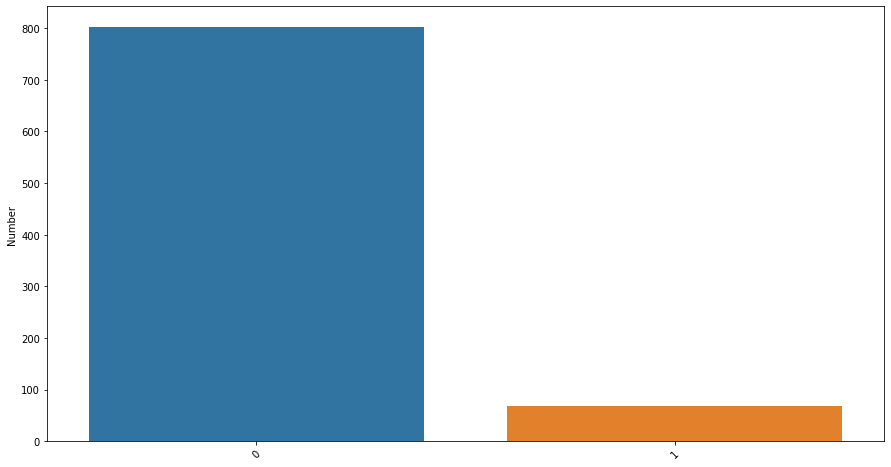

graph is Size , and the total number is 8


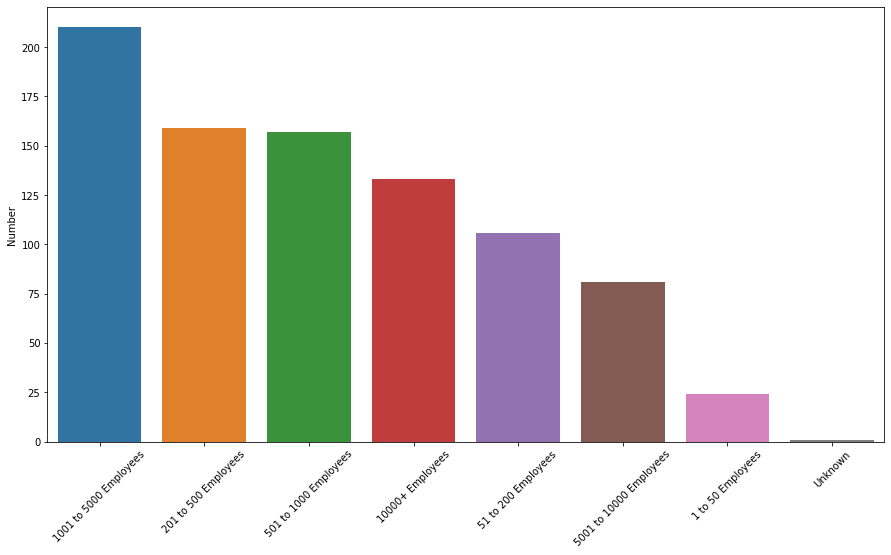

In [112]:
#lets draw some bar graphs for the categorical features
for i in df_cat.columns:
    plt.figure(figsize = (15,8))
    cat_num = df_cat[i].value_counts()[:15]
    print("graph is %s , and the total number is %d" %(i,len(cat_num)))
    ax = sns.barplot(x = cat_num.index , y = cat_num)
    ax.set_xticklabels(ax.get_xticklabels() , rotation = 45)
    ax.set(ylabel = 'Number')
    plt.show()
    

In [113]:
pd.pivot_table(df, index = ['title','seniority'] , values ='avg_salary')
# it is wierd. Seniors are getting paid lower than juniors. Lets take this column out.

avg_salary
title                      seniority            
data analyst               0            3.043930
                           1            3.194686
data engineer              0            3.257916
                           1            3.354867
data scientist             0            3.303370
                           1            3.435170
machine learning engineerr 0            3.341104
                           1            3.446812

In [114]:
pd.pivot_table(df, index = 'Industry' , values ='avg_salary')

,avg_salary
Industry,
Advertising & Marketing,3.189833
Aerospace & Defense,3.284613
Biotech & Pharmaceuticals,3.308329
Colleges & Universities,2.853454
Computer Hardware & Software,3.260088
Consulting,3.177594
Energy,3.201544
Enterprise Software & Network Solutions,3.347449
Federal Agencies,3.301653


In [115]:
pd.pivot_table(df, index = 'state' , values ='avg_salary').sort_values('avg_salary',ascending =False)

,avg_salary
state,
CA,3.323893
MA,3.275369
UT,3.273941
VA,3.258110
NJ,3.240417
RI,3.228136
MN,3.227184
MD,3.220975
DC,3.220661


In [116]:
# doing some text analysis on the job description
from wordcloud import WordCloud , STOPWORDS
from nltk.corpus import stopwords;
from nltk.tokenize import word_tokenize
#nltk.download('all')

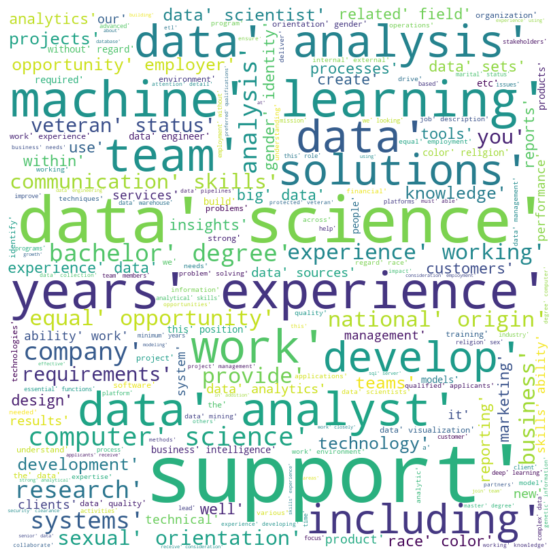

In [65]:
words = " ".join(df['Job Description'])
def pucntuation_remover(input_text):
    filtered = []
    word_token = word_tokenize(input_text)
    stop_words = set(stopwords.words('english'))
    for i in word_token:
        if i not in stop_words and i.isalpha():
            filtered.append(i.lower())
    return filtered
text = pucntuation_remover(words)
wc = WordCloud(width = 800 , height = 800 , background_color = 'white' , stopwords = STOPWORDS)
wc.generate(str(text))
plt.figure(figsize  = (10,10))
plt.imshow(wc , interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [117]:
# df = df.loc[df.avg_salary > 40]
df.to_csv('eda_data_modified')

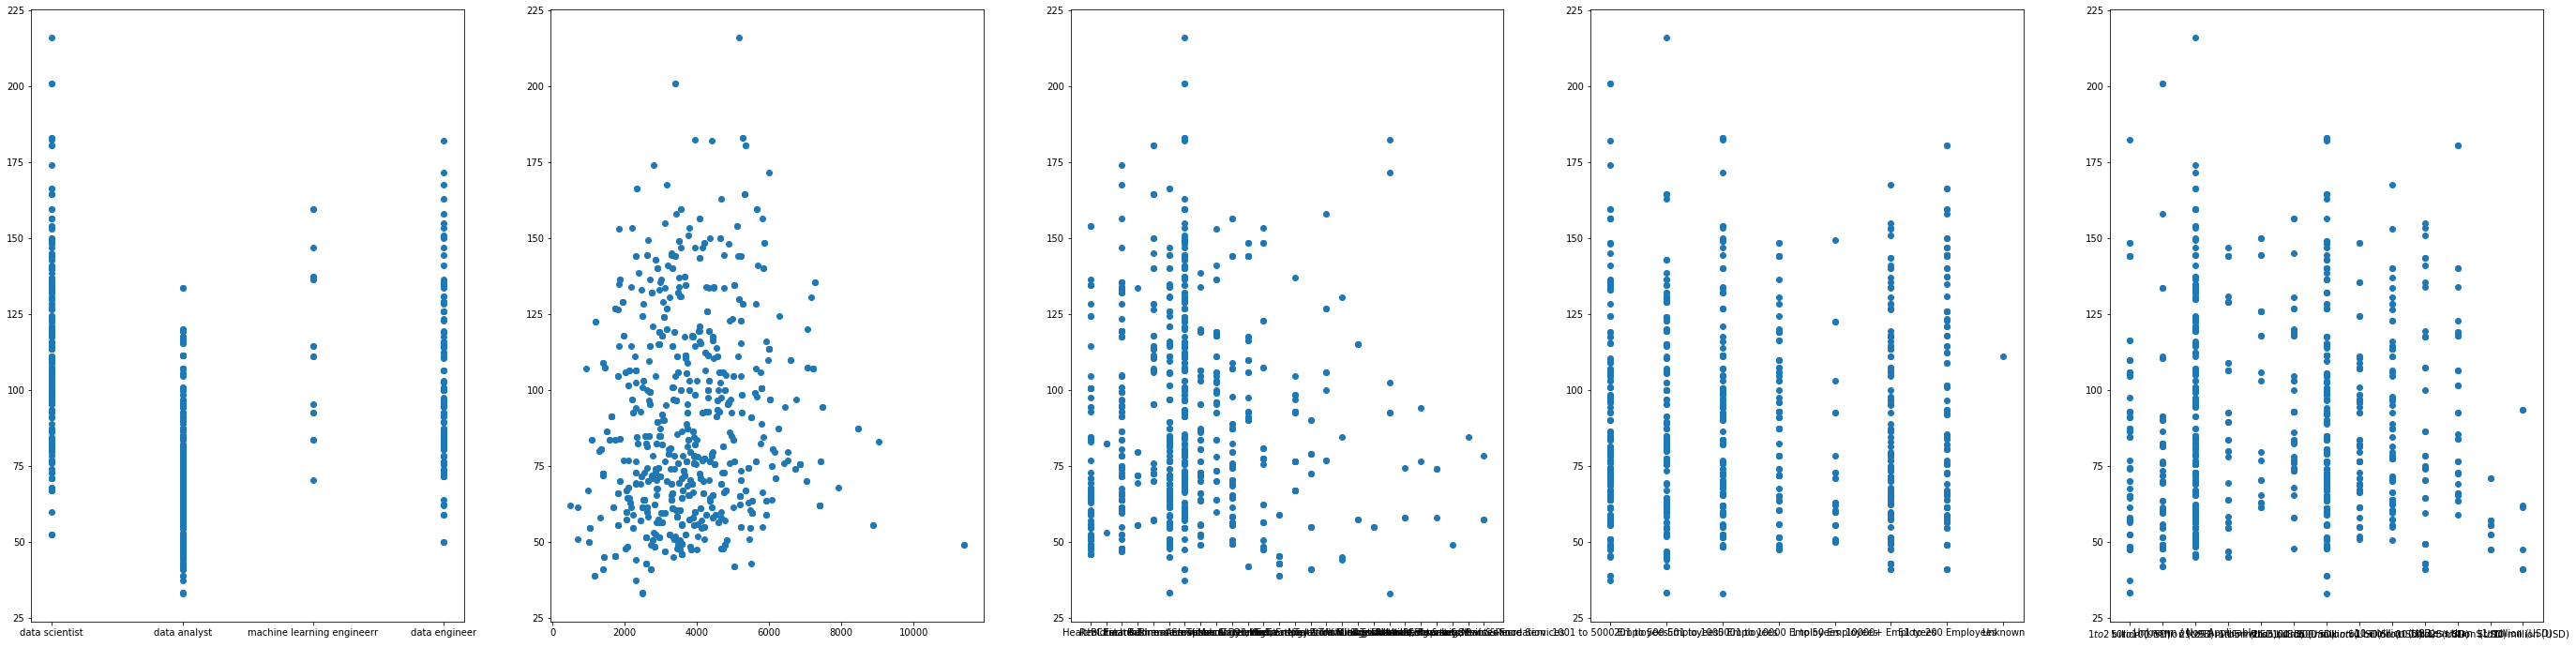

In [67]:
fig , (ax1, ax2, ax3 , ax4 , ax5) = plt.subplots(1,5 , figsize = (48,12))
ax1.scatter(df['title'],df['avg_salary'])
ax2.scatter(df['desc_length'],df['avg_salary'])
ax3.scatter(df['Sector'],df['avg_salary'])
ax4.scatter(df['Size'],df['avg_salary'])
ax5.scatter(df['Revenue'],df['avg_salary'])

In [84]:
df.salary_type.value_counts()

(Glassdoor                   1103
(Employer                      28
Employer Provided Salary:      16
Per                             9
Name: salary_type, dtype: int64